<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher/blob/main/xpAnalysis_Vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vit_pytorch timm
#timmとは、Ross Wightman によって作成された深層学習ライブラリ。

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.3 MB/s eta 0:00:00


# ライブラリのインストール

In [3]:
from __future__ import print_function

import glob#glob“はPython標準のライブラリの一つでディレクトリに格納されたファイル名を抽出する
import os#osモジュールは、OSに依存しているさまざまな機能を利用するためのモジュール
import random#randomモジュールは、Pythonでランダムな処理が必要な場合に活躍する標準モジュール
import cv2#画像や動画の処理ができる機能がまとめられたオープンソースライブラリ
# Google Colab環境下ならcv2の代わりにこれを使用する
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import numpy as np#NumPyは、Pythonに対して型付きの多次元配列オブジェクト (numpy.ndarray) と、その配列に対する多数の演算関数や操作関数を提供
import pandas as pd#pandasは、データ解析を支援する機能を提供するライブラリで、数表および時系列データを操作するためのデータ構造と演算を提供する
import torch#Facebookが開発を主導したPython向けの機械学習ライブラリ
import torch.nn as nn#nnとはneural networkの略
import torch.nn.functional as F#PyTorchでモデル（ネットワーク）を構築・生成するための関数を提供する
import torch.optim as optim#オプティマイザーを提供する
from PIL import Image
from torch.optim.lr_scheduler import StepLR#スケジューラーは学習の過程における学習率の変化を規定する
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms#pytorch_lightningを使用しないのはなぜ？
from tqdm.notebook import tqdm#tqdmは進捗状況や処理状況をプログレスバー（ステータスバー）として表示する機能

from vit_pytorch.efficient import ViT#ViTをPytorchで実装したモジュール
from pathlib import Path#pathlibモジュールは、ファイル・ディレクトリのパスを、オブジェクトとして操作できるモジュール
import seaborn as sns#データ可視化のためのライブラリで、複雑なデータをシンプルなコードでグラフ化。Matplotlibと比べて、よりデザイン性の高いグラフを作ることが可能
import timm
from pprint import pprint

# 学習条件、ランダムシードの設定

In [4]:
# Training settings
epochs = 100
# lr = 0.01
lr = 1e-3#学習率(learning rate: lr)
gamma = 0.7#更新率。デフォルトは0.1。この場合、更新タイミングで学習率が1/10になる
seed = 42#乱数のシード。慣用的に42が使用されることが多い。
#「銀河ヒッチハイク・ガイド」という書籍の中で登場するスーパーコンピューターのディープ・ソートが「生命、宇宙、そして万物についての究極の疑問の答え」として計算した数字

In [5]:
def seed_everything(seed):#使用するモジュールにおける乱数のシードを統一し、再現性を確保している。
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)#その他さまざまなtorchに含まれる非決定的な計算過程を決定的なものにして再現性を確保している

In [6]:
# GPUの設定
device = 'cuda'

# データセットの前処理

In [13]:
from torchvision import transforms

# 前処理の定義
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),#モデルが要求するサイズに画像サイズを変更する
        transforms.RandomResizedCrop(224),#データ拡張過程。ランダムに切り抜いてからモデルが要求するサイズに画像サイズを変更する
        transforms.RandomHorizontalFlip(),#データ拡張過程。ランダムに水平方向に反転させる
        transforms.ToTensor(),#画像の行列化
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#行列化した画像の正規化
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

# データセットのロード

In [14]:
from sklearn.model_selection import train_test_split

# 画像とCSVファイルのパス
image_dir = "/content/drive/MyDrive/xpFiles_png"
csv_file_path = "/content/drive/MyDrive/xpFilesTable_v1.1.csv"

# CSVファイルからデータを読み込み
dataframe = pd.read_csv(csv_file_path)

# 訓練データと検証データに分割
train_df, valid_df = train_test_split(dataframe, test_size=0.2, random_state=seed)

# カスタムデータセットクラス
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, -1]) # file_path columnを使用
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 4] # gender columnを使用（必要に応じて変更）

        if self.transform:
            image = self.transform(image)

        return image, label

# 訓練データと検証データのデータセット
train_data = CustomDataset(dataframe=train_df, image_dir=image_dir, transform=train_transforms)
valid_data = CustomDataset(dataframe=valid_df, image_dir=image_dir, transform=val_transforms)

# データローダ
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=64, shuffle=True)

In [24]:
from sklearn.model_selection import train_test_split

# 画像とCSVファイルのパス
image_dir = "/content/drive/MyDrive/xpFiles_png"
csv_file_path = "/content/drive/MyDrive/xpFilesTable_v1.1.csv"

# CSVファイルからデータを読み込み
dataframe = pd.read_csv(csv_file_path)

# 訓練データと検証データに分割
train_df, valid_df = train_test_split(dataframe, test_size=0.2, random_state=seed)

# カスタムデータセットクラス
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
      img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 4]) # file_path columnを使用
      image = Image.open(img_name)
      gender = self.dataframe.iloc[idx, 2] # gender columnを使用
      if gender == 'm':
        label = torch.tensor(0, dtype=torch.long)
      else:
        label = torch.tensor(1, dtype=torch.long)
      if self.transform:
        image = self.transform(image)
      return image, label
# 訓練データと検証データのデータセット
train_data = CustomDataset(dataframe=train_df, image_dir=image_dir, transform=train_transforms)
valid_data = CustomDataset(dataframe=valid_df, image_dir=image_dir, transform=val_transforms)

# データローダ
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=64, shuffle=True)

データをバッチに分ける。

今回バッチサイズは16にするが、メモリが足らない場合は数字をあげる。

# Vitモデルのロード


In [26]:
model_names = timm.list_models(pretrained=True)
# ファインチューニングしたい場合はpretrained=True
# model_names = timm.list_models(pretrained=True)
#pprint(model_names)

今回は'vit_base_patch16_224_in21k'を選んでみる

In [27]:
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)
# 訓練済みデータを使用しない場合はpretrained=Falseとする。訓練済みデータを使用し、ファインチューニングしたい場合はpretrained=True
# model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)

# modelをGPUで動作させる
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

# Vit学習

損失関数、活性化関数の設定をする。

今回はクロスエントロピーロス、アダムを使う。

In [28]:
# loss function
criterion = nn.CrossEntropyLoss()#正常と異常の２値分類であるためクロスエントロピー法を用いる。
# criterion = nn.HuberLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)#パラメーターはデフォルト値を使用する。学習率は上記に定めたものを使用
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

学習ループを設定し、実行していく

In [29]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
    #ここからが訓練用データの解析
for epoch in range(epochs):#訓練するエポックの数だけループを行う。エポック数は全データセットを何回学習に通すかを示す。
    epoch_loss = 0#各エポックの初めで、エポックのlossをゼロに初期化する。
    epoch_accuracy = 0#各エポックの初めで、エポックのaccuracyをゼロに初期化する。

    for data, label in tqdm(train_loader):#訓練データローダーからバッチを取得する。tqdmはプログレスバーを表示するためのライブラリ。
        data = data.to(device)#取得した画像をGPUに移す（もしCUDAが利用可能なら）。deviceは通常、'cuda'または'cpu'となる。
        label = label.to(device)#取得したラベルをGPUに移す。

        output = model(data)#モデルに入力データを通すことで、出力（推定値）を求める。
        loss = criterion(output, label)#出力（推定値）とラベル（実測値）を用いて、損失関数（ここではCross Entropy Loss）を使用して損失を計算する。

        optimizer.zero_grad()#勾配をゼロに初期化する。PyTorchでは勾配が累積されるため、各バッチでゼロにリセットする必要がある。
        loss.backward()#損失関数を用いて求めた損失から、誤差逆伝播法を使用して勾配を計算する。
        optimizer.step()#計算された勾配を用いて、最適化アルゴリズム（ここではAdam）によりモデルのパラメータ（係数と切片）を更新する。

        acc = (output.argmax(dim=1) == label).float().mean()#予測モデルの正確さを計算する。argmax関数で、出力から最も確率が高いクラスを選ぶ。それがラベルと一致しているか確認し、平均値を取る。
        epoch_accuracy += acc / len(train_loader)#バッチごとの正確さを加算する。全バッチを通した後、これらの値はエポック全体の平均した正確さになる。
        epoch_loss += loss / len(train_loader)#バッチごとの損失を加算する。全バッチを通した後、これらの値はエポック全体の平均した損失になる。

    #ここからが検証用データの解析
    with torch.no_grad():#勾配の計算を無効にするコンテキストマネージャ。モデルを評価する際には、勾配の計算は不要であり、計算量を削減することができる。
        epoch_val_accuracy = 0#各エポックの初めで、検証したエポックの正確さをゼロに初期化する。
        epoch_val_loss = 0#各エポックの初めで、検証したエポックの損失をゼロに初期化する。
        for data, label in valid_loader:#検証データローダーからバッチを取得する。
            data = data.to(device)#取得した画像をGPUに移す
            label = label.to(device)#取得したラベルをGPUに移す
        #以降の部分は基本的に訓練ループと同じ。
        #ただし、検証過程ではモデルのパラメータを更新する必要がないため、optimizer.zero_grad(), loss.backward(), optimizer.step()の部分は含まれていない。
            val_output = model(data)#モデルに入力データを通すことで、出力（推定値）を求める。
            val_loss = criterion(val_output, label)#出力（推定値）とラベル（実測値）を用いて、損失関数（ここではCross Entropy Loss）を使用して損失を計算する。

            acc = (val_output.argmax(dim=1) == label).float().mean()#予測モデルの正確さを計算する。
            epoch_val_accuracy += acc / len(valid_loader)#バッチごとの正確さを加算する。
            epoch_val_loss += val_loss / len(valid_loader)#バッチごとの損失を加算する。

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 1 - loss : 5.3474 - acc: 0.5087 - val_loss : 1.8927 - val_acc: 0.6209



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.9903 - acc: 0.5294 - val_loss : 0.8210 - val_acc: 0.3791



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7209 - acc: 0.5443 - val_loss : 0.7139 - val_acc: 0.6070



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.7082 - acc: 0.5778 - val_loss : 0.8246 - val_acc: 0.3651



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6864 - acc: 0.5882 - val_loss : 0.6553 - val_acc: 0.6349



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6706 - acc: 0.6149 - val_loss : 0.6432 - val_acc: 0.6557



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6729 - acc: 0.5926 - val_loss : 0.6628 - val_acc: 0.6209



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6787 - acc: 0.5998 - val_loss : 0.7089 - val_acc: 0.6279



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.7514 - acc: 0.5219 - val_loss : 0.6548 - val_acc: 0.6349



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.7875 - acc: 0.5443 - val_loss : 0.7532 - val_acc: 0.4069



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.7189 - acc: 0.5546 - val_loss : 0.7765 - val_acc: 0.4069



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.7259 - acc: 0.5210 - val_loss : 0.6730 - val_acc: 0.6349



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6701 - acc: 0.6103 - val_loss : 0.6749 - val_acc: 0.5861



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6820 - acc: 0.6164 - val_loss : 0.6567 - val_acc: 0.6279



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6768 - acc: 0.6142 - val_loss : 0.7005 - val_acc: 0.3303



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6699 - acc: 0.5964 - val_loss : 0.6734 - val_acc: 0.6070



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6625 - acc: 0.6221 - val_loss : 0.6490 - val_acc: 0.6279



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6749 - acc: 0.6220 - val_loss : 0.6648 - val_acc: 0.6000



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.7114 - acc: 0.5343 - val_loss : 0.6585 - val_acc: 0.6209



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.7167 - acc: 0.5495 - val_loss : 0.7252 - val_acc: 0.3651



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.7234 - acc: 0.5136 - val_loss : 0.6511 - val_acc: 0.6644



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.7203 - acc: 0.5570 - val_loss : 0.7368 - val_acc: 0.4069



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.6683 - acc: 0.6149 - val_loss : 0.6319 - val_acc: 0.6505



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.6443 - acc: 0.6393 - val_loss : 0.7257 - val_acc: 0.6326



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.6731 - acc: 0.6250 - val_loss : 0.6254 - val_acc: 0.6731



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.6709 - acc: 0.6380 - val_loss : 0.6468 - val_acc: 0.6461



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.6939 - acc: 0.5984 - val_loss : 0.7861 - val_acc: 0.3651



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.7184 - acc: 0.5768 - val_loss : 0.6207 - val_acc: 0.6535



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.6515 - acc: 0.6370 - val_loss : 0.6298 - val_acc: 0.6613



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.6721 - acc: 0.6152 - val_loss : 0.7249 - val_acc: 0.3651



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.6970 - acc: 0.5687 - val_loss : 0.8200 - val_acc: 0.6140



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.7246 - acc: 0.5751 - val_loss : 0.6157 - val_acc: 0.7009



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.6741 - acc: 0.6082 - val_loss : 0.6917 - val_acc: 0.3886



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.6918 - acc: 0.5766 - val_loss : 0.7482 - val_acc: 0.6396



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.7295 - acc: 0.5802 - val_loss : 0.8220 - val_acc: 0.3930



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.6970 - acc: 0.6027 - val_loss : 0.7096 - val_acc: 0.6187



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.6660 - acc: 0.6500 - val_loss : 0.6285 - val_acc: 0.6731



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.6865 - acc: 0.6381 - val_loss : 0.6864 - val_acc: 0.4100



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.6960 - acc: 0.5832 - val_loss : 0.7008 - val_acc: 0.6396



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.6708 - acc: 0.6242 - val_loss : 0.6720 - val_acc: 0.6544



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.6443 - acc: 0.6475 - val_loss : 0.7285 - val_acc: 0.4681



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.6507 - acc: 0.6492 - val_loss : 0.6525 - val_acc: 0.6574



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.6263 - acc: 0.6718 - val_loss : 0.6604 - val_acc: 0.6513



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.6225 - acc: 0.6566 - val_loss : 0.6299 - val_acc: 0.6231



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.6135 - acc: 0.6708 - val_loss : 0.6660 - val_acc: 0.6109



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.6165 - acc: 0.6729 - val_loss : 0.6697 - val_acc: 0.6022



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.6220 - acc: 0.6619 - val_loss : 0.6568 - val_acc: 0.6162



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.6312 - acc: 0.6786 - val_loss : 0.6385 - val_acc: 0.6287



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.6197 - acc: 0.6880 - val_loss : 0.6784 - val_acc: 0.6466



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.6016 - acc: 0.7006 - val_loss : 0.6318 - val_acc: 0.6848



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.6222 - acc: 0.6669 - val_loss : 0.6484 - val_acc: 0.6179



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.6158 - acc: 0.7066 - val_loss : 0.6320 - val_acc: 0.6613



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.6296 - acc: 0.6548 - val_loss : 0.6090 - val_acc: 0.6605



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.6153 - acc: 0.6864 - val_loss : 0.6209 - val_acc: 0.6574



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.6115 - acc: 0.6954 - val_loss : 0.6523 - val_acc: 0.6636



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.6288 - acc: 0.6871 - val_loss : 0.6536 - val_acc: 0.6179



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.6745 - acc: 0.6806 - val_loss : 0.7865 - val_acc: 0.4159



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.6421 - acc: 0.6666 - val_loss : 0.6382 - val_acc: 0.6692



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.5905 - acc: 0.7178 - val_loss : 0.6493 - val_acc: 0.6522



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.6042 - acc: 0.7050 - val_loss : 0.6123 - val_acc: 0.6792



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.5932 - acc: 0.7150 - val_loss : 0.6078 - val_acc: 0.7104



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.5969 - acc: 0.7058 - val_loss : 0.6279 - val_acc: 0.6865



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.5980 - acc: 0.7021 - val_loss : 0.6263 - val_acc: 0.6522



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.6099 - acc: 0.6905 - val_loss : 0.6660 - val_acc: 0.6917



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.5888 - acc: 0.7214 - val_loss : 0.6742 - val_acc: 0.6753



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.6245 - acc: 0.6905 - val_loss : 0.6274 - val_acc: 0.7182



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.5832 - acc: 0.7026 - val_loss : 0.6613 - val_acc: 0.6605



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.5865 - acc: 0.7189 - val_loss : 0.6420 - val_acc: 0.6566



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.5873 - acc: 0.7312 - val_loss : 0.6485 - val_acc: 0.6895



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.5746 - acc: 0.7375 - val_loss : 0.6547 - val_acc: 0.6856



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.5819 - acc: 0.7235 - val_loss : 0.6415 - val_acc: 0.6700



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.5946 - acc: 0.7152 - val_loss : 0.6823 - val_acc: 0.6435



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.5761 - acc: 0.7361 - val_loss : 0.6388 - val_acc: 0.6809



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.6168 - acc: 0.7245 - val_loss : 0.6215 - val_acc: 0.6800



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.5847 - acc: 0.7237 - val_loss : 0.5693 - val_acc: 0.7035



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.5769 - acc: 0.7292 - val_loss : 0.6300 - val_acc: 0.6848



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.5622 - acc: 0.7382 - val_loss : 0.6835 - val_acc: 0.6834



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.5717 - acc: 0.7382 - val_loss : 0.6652 - val_acc: 0.6739



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.6068 - acc: 0.7040 - val_loss : 0.6733 - val_acc: 0.6974



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.5760 - acc: 0.7375 - val_loss : 0.6655 - val_acc: 0.6561



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.5907 - acc: 0.7168 - val_loss : 0.6382 - val_acc: 0.6778



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.5917 - acc: 0.7109 - val_loss : 0.6565 - val_acc: 0.6474



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.5893 - acc: 0.7245 - val_loss : 0.6382 - val_acc: 0.6800



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.5588 - acc: 0.7411 - val_loss : 0.6957 - val_acc: 0.6669



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.5504 - acc: 0.7461 - val_loss : 0.6574 - val_acc: 0.6770



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.5853 - acc: 0.7259 - val_loss : 0.6468 - val_acc: 0.6656



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.5532 - acc: 0.7535 - val_loss : 0.6154 - val_acc: 0.7160



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.5759 - acc: 0.7270 - val_loss : 0.6667 - val_acc: 0.6452



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.6034 - acc: 0.7168 - val_loss : 0.6800 - val_acc: 0.6826



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.5896 - acc: 0.7333 - val_loss : 0.6219 - val_acc: 0.7013



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.5707 - acc: 0.7351 - val_loss : 0.6619 - val_acc: 0.6809



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.5531 - acc: 0.7528 - val_loss : 0.5809 - val_acc: 0.7425



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.5531 - acc: 0.7503 - val_loss : 0.6425 - val_acc: 0.7143



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.5669 - acc: 0.7419 - val_loss : 0.7048 - val_acc: 0.6831



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.5656 - acc: 0.7520 - val_loss : 0.6487 - val_acc: 0.6982



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.5531 - acc: 0.7463 - val_loss : 0.6220 - val_acc: 0.6934



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.5359 - acc: 0.7579 - val_loss : 0.5924 - val_acc: 0.7300



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.5302 - acc: 0.7610 - val_loss : 0.6721 - val_acc: 0.6656



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.5503 - acc: 0.7445 - val_loss : 0.6177 - val_acc: 0.6965



  0%|          | 0/14 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.5491 - acc: 0.7372 - val_loss : 0.6174 - val_acc: 0.7043



# 学習結果の可視化

<ipython-input-30-a14de596ddeb>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


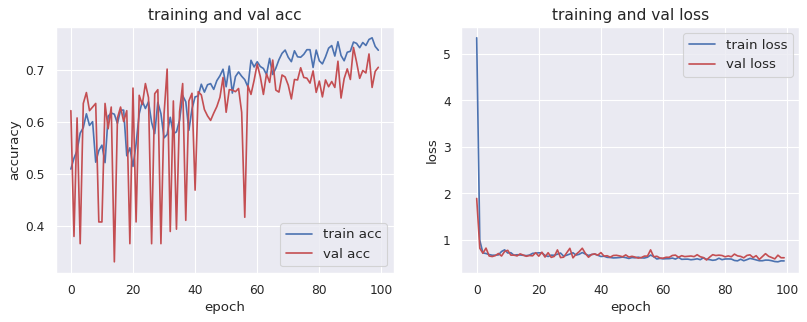

In [30]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)

    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)

    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)

    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

# 結果と考察

## 結果

- val acc：0.61程度なので精度としては微妙(v1よりは上がった)
- train acc:073程度なので過学習というよりは局所最適解の可能性（v1よりも正解率はは上がった）
- 最低でもval acc:0.7程度無いと希望が持てないレベル

## 考察

- パーの形のみのデータセットにした結果、正解率は上がった。
- 各画像に濃淡差があるので、前処理しても良いかもしれない。
- 他のモデルも検討してみる。（大きな改善は見込めない）